# Data Preparation

## Packages

In [1]:
import os
import winsound
import numpy as np
import pandas as pd
import datetime as dt
from tqdm import tqdm

import math, collections
from scipy.stats import linregress

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_slope_s(y_axis):
    global window_s_ma
    x_axis = []
    for i in range(window_s_ma):
        x_axis.append(1 + ((i+1) * 0.0001 * 0.1))
    
    slope_tick, intercept, _, _, _ = linregress(x_axis, y_axis)
    slope_tick = math.degrees(math.atan(slope_tick))
    
    return(slope_tick)

def get_slope_l(y_axis):
    global window_l_ma
    x_axis = []
    for i in range(window_l_ma):
        x_axis.append(1 + ((i+1) * 0.0001 * 0.1))
    
    slope_tick, intercept, _, _, _ = linregress(x_axis, y_axis)
    slope_tick = math.degrees(math.atan(slope_tick))
    
    return(slope_tick)


def get_month(row):
    month_val = dt.datetime.strptime(row['TS'], '%Y-%m-%d %H:%M').date().month
    return(month_val)

def get_day(row):
    day_val = dt.datetime.strptime(row['TS'], '%Y-%m-%d %H:%M').date().day
    return(day_val)   

def get_hour(row):
    hour_val = dt.datetime.strptime(row['TS'], '%Y-%m-%d %H:%M').time().hour
    return(hour_val)   

def get_min(row):
    min_val = dt.datetime.strptime(row['TS'], '%Y-%m-%d %H:%M').time().minute
    return(min_val)   


def get_dow(row):
    dow = dt.datetime.strptime(df['TS'][0], '%Y-%m-%d %H:%M').weekday()
    return(dow)

In [3]:
def chunk_ticks(df, number_of_ticks):   
    global pip_diff
    
    df['tick'] = (df['Bid'] + df['Ask'])/2
    df = df[['tick']]

    temp_df = pd.DataFrame()
    open_list = []
    high_list = []
    low_list = []
    close_list = []
    avg_list = []

    for i in tqdm(range(0,len(df),number_of_ticks)):
        chunk_list = list(df['tick'][i:i+number_of_ticks])

        open_val = chunk_list[0]
        high_val = np.max(chunk_list)
        low_val = np.min(chunk_list)
        close_val = chunk_list[-1]
        avg_val =  np.mean(chunk_list)
        
        open_list.append(open_val) 
        high_list.append(high_val)
        low_list.append(low_val)
        close_list.append(close_val) 
        avg_list.append(avg_val)

    temp_df['open'] = open_list
    temp_df['high'] = high_list
    temp_df['low'] = low_list    
    temp_df['close'] = close_list  
    temp_df['avg'] = avg_list  
    
    return(temp_df)

## Parameters

In [4]:
#pd.DataFrame(np.random.rand(14,4), columns=['a', 'b', 'c', 'd'])

year = 2019
source_file_path = f'data/tick_{year}.csv'

number_of_ticks = 60
pip_diff = 0.0001

diff_col = 'mid'

rsi_window = 10
rs_max = 1e6

window_s_ma = 10
window_l_ma = 50

## Read data

In [5]:
%%time
path, file_name = os.path.split(source_file_path)

target_file_name = 'tab_'+file_name
target_file_path = os.path.join(path, target_file_name)

df = pd.read_csv(source_file_path, nrows=10000)
#df = pd.read_csv(source_file_path)

Wall time: 13 ms


In [6]:
print(f'Total recs : {len(df)}')
df = chunk_ticks(df, number_of_ticks)
print(f'Reduced recs : {len(df)}')
df.head()

100%|██████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 6977.48it/s]

Total recs : 10000
Reduced recs : 167


,open,high,low,close,avg
0,1.14640,1.146700,1.146220,1.146700,1.146434
1,1.14670,1.146740,1.146630,1.146685,1.146692
2,1.14669,1.146770,1.146400,1.146435,1.146543
3,1.14644,1.146440,1.146215,1.146220,1.146387
4,1.14623,1.146415,1.146220,1.146260,1.146308


## Data manipulation

In [7]:
df['mid'] = (df['high'] + df['low'] )/2

In [8]:
df.head()

,open,high,low,close,avg,mid
0,1.14640,1.146700,1.146220,1.146700,1.146434,1.146460
1,1.14670,1.146740,1.146630,1.146685,1.146692,1.146685
2,1.14669,1.146770,1.146400,1.146435,1.146543,1.146585
3,1.14644,1.146440,1.146215,1.146220,1.146387,1.146328
4,1.14623,1.146415,1.146220,1.146260,1.146308,1.146317


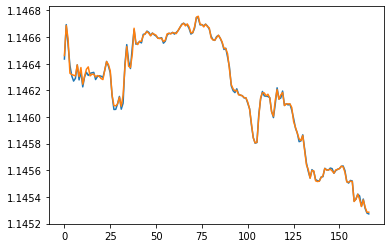

In [10]:
plt.plot(df['avg'])
plt.plot(df['mid'])

In [ ]:
df['diff'] = df['mid'].diff()
df['gain'] = 0
df['loss'] = 0
df['gain'].loc[df['diff'] > 0] = abs(df['diff'])
df['loss'].loc[df['diff'] < 0] = abs(df['diff'])

df['avg_gain'] = df['gain'].rolling(window=rsi_window).mean()
df['avg_loss'] = df['loss'].rolling(window=rsi_window).mean()

df['rs'] = df['avg_gain']/df['avg_loss']
df['rs'] = df['rs'].where(df['rs'] <= rs_max, rs_max) 
df['rsi'] = 100 - (100 / (df['rs'] + 1))

df['ssma'] = df['mid'].rolling(window=window_s_ma).mean()
df['slope_s_m'] = df['mid'].rolling(window=window_s_ma).apply(get_slope_s)

df['direction'] = 'same'
df['direction'].loc[df[diff_col].shift(-1) - df[diff_col] > pip_diff] = 'increase'
df['direction'].loc[df[diff_col].shift(-1) - df[diff_col] < -pip_diff] = 'decrease'


#df['lsma'] = df['close'].rolling(window=window_l_ma).mean()
#df['sma_diff'] = df['ssma'] - df['lsma']

#df['sema'] = df['close'].ewm(span=window_s_ma).mean()
#df['lema'] = df['close'].ewm(span=window_l_ma).mean()
#df['ema_diff'] = df['sema'] - df['lema']

# df['slope_s_h'] = df['high'].rolling(window=window_s_ma).apply(get_slope_s)
# df['slope_s_l'] = df['low'].rolling(window=window_s_ma).apply(get_slope_s)
# df['slope_s_o'] = df['open'].rolling(window=window_s_ma).apply(get_slope_s)

#df['slope_l'] = df['close'].rolling(window=window_l_ma).apply(get_slope_l)
#df['sma_slope'] = df['ssma'].rolling(window=rsi_window).apply(get_slope)



df = df.dropna()
df = df.reset_index(drop=True)
df.head()

## Write data to csv

In [ ]:
#remove_columns = ['target_gain', 'target_loss']
#df = df[df.columns.difference(remove_columns)]

df.to_csv(target_file_path, index = False)
winsound.PlaySound('C:\\Windows\\Media\\tada.wav', winsound.SND_ASYNC)

## Print Report

In [ ]:
g= df['direction']
print(pd.concat([g.value_counts(), g.value_counts(normalize=True).mul(100)],axis=1, keys=('counts','percentage')))
df.head(10)